# HeartDisease Classification
## Project Overview
This training project develops a prediction model of risk for heart disease in patients. Potential usecases are automatic first screening of incoming patients for risk of heart disease in hospitals or usage of the resulting tree structure as heuristic for medical professionals. 

This analysis is a slightly modified version of an existing Statquest Jupyter Notebook (different dataset).

###Preparation and Data import

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
path = 'C:\\Pythontest Anaconda\\Statquest\\projects\\HeartDisease'
df = pd.read_csv(path + "\\00_data\\" + "processed.cleveland.data")
df.columns = ["age", "sex","cp", "restbp", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "hd"]


- Identify Missing Data (observations where one of the attributes has blank space / 'na') --> columns 'ca' and 'thal' had some observations with the attribute value '?' 
- Show Observations with missing values


In [61]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]


,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
86,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
165,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
191,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
265,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
286,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
301,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


6 out of 303 rows
Note: Categorical Data is given as numbers (eg. 'sex': male = 0, female = 1)

### Data Wrangling

- Missing Values: Needs to be dealt with in one of two ways(Remove or impute/'educated guess') - Classification method cannot have missing value data in the training set
- Chosen here: Remove the observations with missing values

In [43]:
df_nomissing = df.loc[((df['ca'] != '?') & (df['thal'] != '?'))]

#Data Formating

- Split Data into Independent variables (X) and Dependent variable (y)
- Set up Independent Variables df: Make a copy of the given data without the dependent variable 'heart disease'. Use 'real' copying, as opposed to default copy-by-reference

In [44]:
X = df_nomissing.drop('hd', axis = 1).copy()

### Set up Dependent Variables df (heart disease)

In [45]:
y = df_nomissing['hd'].copy()

### Background
-  Original Data Format as follows: Some variables are float. Remaining variables are categorical --> Encoded as integers 0, 1, 2, 3, ... with respective values
-  To utilize categorical variabes in a scikit-learn decision tree, the categorical values need to be transformed so that they are given as specific columns of boolean value  (0 = No /1 = Yes)
-  We use encoding method "One-hot Encoding" to do that. Example "Chest Pain" ('cp'). The pandas method is called "get_dummies()" (get dummy columns)


In [46]:
X['cp'].unique() #'Chestpain' variable has only 4 possible values

array([4., 3., 2., 1.])

Categorical Columns in Dataframe 'X' transformed such that they are binary --> Ready for using  in Decisiontree


In [47]:
X_encoded = pd.get_dummies(X, columns = ['cp', 'restecg', 'slope', 'thal'])
X_encoded.head() # Test if format transform has worked OK

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
1,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
2,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
3,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0
4,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,0.0,0,...,0,1,0,0,1,0,0,1,0,0


Transform the dependent variable y: Original is values for likelihood of heart disease on scale 1-5. For simplification of the tree, the values > 1 (= 'chance of heart disease') will be transformed to boolean value 'Heart Disease Yes/No'.


In [48]:
y_index_notZero = y > 0
y[y_index_notZero] = 1
y.unique()

array([1, 0], dtype=int64)

### Tree-building
- Build Preliminary Tree --> Basis for iterative improvement
- Split the data in X and respective dependent variables in y into training and testing sets. Proportion of Training observations <-> Test observations is default value 70 / 30.


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state = 42) #Random seed for the splitting --> Reproducible


clf_dt = DecisionTreeClassifier(random_state = 42) #Initialize Classifier Object
clf_dt.fit(X = X_train, y = y_train) #Fit to the training data

DecisionTreeClassifier(random_state=42)

### First round of evaluation
- Visualize for quick evaluation 

[Text(0.5194444444444445, 0.9444444444444444, 'X[12] <= 0.5\ngini = 0.499\nsamples = 222\nvalue = [116, 106]'),
 Text(0.2611111111111111, 0.8333333333333334, 'X[17] <= 0.5\ngini = 0.354\nsamples = 113\nvalue = [87, 26]'),
 Text(0.14444444444444443, 0.7222222222222222, 'X[2] <= 185.0\ngini = 0.198\nsamples = 72\nvalue = [64, 8]'),
 Text(0.12222222222222222, 0.6111111111111112, 'X[0] <= 56.5\ngini = 0.178\nsamples = 71\nvalue = [64, 7]'),
 Text(0.044444444444444446, 0.5, 'X[18] <= 0.5\ngini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(0.022222222222222223, 0.3888888888888889, 'gini = 0.0\nsamples = 40\nvalue = [40, 0]'),
 Text(0.06666666666666667, 0.3888888888888889, 'X[19] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.044444444444444446, 0.2777777777777778, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.08888888888888889, 0.2777777777777778, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.2, 0.5, 'X[0] <= 59.5\ngini = 0.355\nsamples = 26\nvalue = [20, 6]'),
 Te

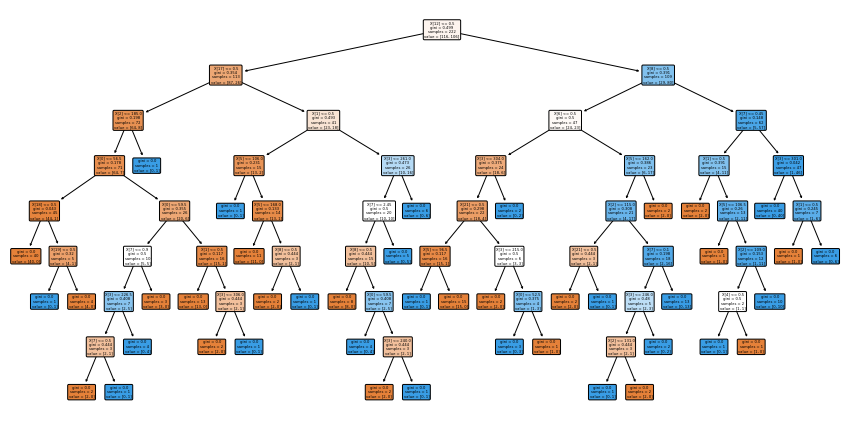

In [50]:

plt.figure(figsize = (15,7.5))
plot_tree(clf_dt, filled = True, rounded = True) #Plot the tree


### Evaluation: Tree is too large for meaningful interpretation / possible overfitting. Possibly prune tree

Check performance with test set data and directly show the results in a confusion matrix. Normalize the confusion matrix (percentage of different groups as opposed to case counts)


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


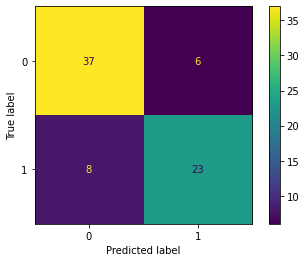

In [51]:
plot_confusion_matrix(clf_dt, X_test, y_test)

Result: 11% False Negative. 8% False Positive


### Improve the tree: Pruning to prevent overfitting
Method: Pruning based on Cost Complexity. The degree of pruning is defined by parameter 'alpha'. Approach is to find optimal alpha based on evaluating accuracy (confusion matrix) for different values of alpha.



In [52]:

path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #determine values for alpha (minimal cost complexity pruning path)
ccp_alphas = path.ccp_alphas #Extract different values for cost complexity alpha  
ccp_alphas = ccp_alphas[:-1] #Excludes the maximum value for alpha (otherwise the decision tree will be pruned until the root node)

clf_dts = [] #Array to be filled with classification decision trees resulting from the different alpha values


The loop creates a tree per value of alpha in the pruning path and fills it into the array of trees

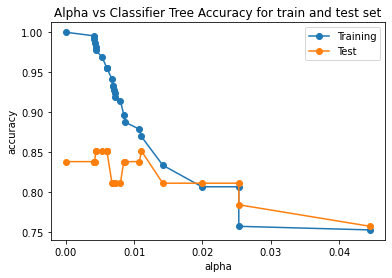

In [53]:
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts] #Score: Return mean accuracy for the given train data
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts] #Score: Return mean accuracy for the given test data

fig, ax = plt.subplots()
ax.plot(ccp_alphas, train_scores, marker = 'o', label = 'Training')
ax.plot(ccp_alphas, test_scores, marker = 'o', label = 'Test')
ax.legend()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Alpha vs Classifier Tree Accuracy for train and test set')
plt.show()

### Evaluation
Rising alpha value represents reduction in overfitting/increase in model bias. Prediction accuracy on the test set is highest (85%) around alpha == 0.01 --> set ccp_alpha = 0.01


### Cross validation to evaluate, whether the previous result holds over different split-ups of the available data into training and test
cross_val_score(): 1. Split available data up different way, 2. Evaluate the classification tree for this new dataset



<AxesSubplot:xlabel='tree'>

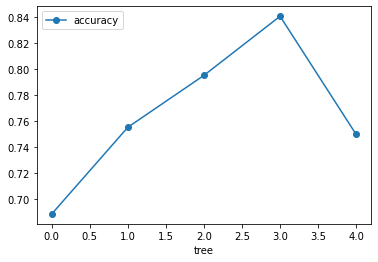

In [54]:
clf_dt_forCV = DecisionTreeClassifier(random_state=42, ccp_alpha = 0.016) #New Tree
scores = cross_val_score(clf_dt_forCV,X_train, y_train, cv = 5) #5-fold Cross Validation from the given training set
df_treeAccuracy = pd.DataFrame(data = {'tree':range(5), 'accuracy': scores})

df_treeAccuracy.plot(x = 'tree', y = 'accuracy', marker = 'o') 

Evaluation: The tree accuracy value is sensitive to the dataset (minimum is ~70%, maximum is 85%)


In [55]:

alpha_loop_values = [] 



5-Fold Cross validation for each candidate value for alpha


In [56]:
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
    
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns = ['alpha', 'mean_accuracy', 'std'])



### Plot results as boxplot to choose ideal alpha


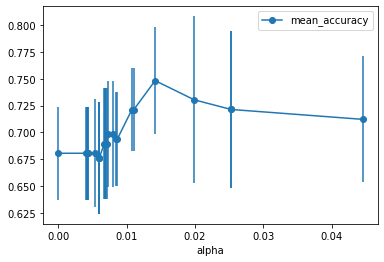

In [57]:
alpha_results.plot( x = 'alpha', 
                   y = 'mean_accuracy',
                   yerr = 'std',
                   marker = 'o')

ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.014)
                                &
                                (alpha_results['alpha'] < 0.019)] ['alpha']
                                
ideal_ccp_alpha = float(ideal_ccp_alpha.unique()) #Result: 0.014190014190014191

### Build Final tree


In [58]:
clf_dt_final = DecisionTreeClassifier(random_state = 42, ccp_alpha = ideal_ccp_alpha)
clf_dt_final.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.014190014190014191, random_state=42)

### Evaluate Confusion Matrix for comparison with original tree


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


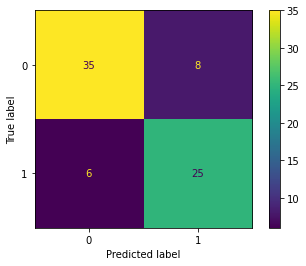

In [59]:
plot_confusion_matrix(clf_dt_final, X_test, y_test)


### Drawing the improved tree to compare structure


[Text(0.5, 0.875, 'X[12] <= 0.5\ngini = 0.499\nsamples = 222\nvalue = [116, 106]'),
 Text(0.2, 0.625, 'X[17] <= 0.5\ngini = 0.354\nsamples = 113\nvalue = [87, 26]'),
 Text(0.1, 0.375, 'gini = 0.198\nsamples = 72\nvalue = [64, 8]'),
 Text(0.3, 0.375, 'X[1] <= 0.5\ngini = 0.493\nsamples = 41\nvalue = [23, 18]'),
 Text(0.2, 0.125, 'gini = 0.231\nsamples = 15\nvalue = [13, 2]'),
 Text(0.4, 0.125, 'gini = 0.473\nsamples = 26\nvalue = [10, 16]'),
 Text(0.8, 0.625, 'X[8] <= 0.5\ngini = 0.391\nsamples = 109\nvalue = [29, 80]'),
 Text(0.7, 0.375, 'X[6] <= 0.5\ngini = 0.5\nsamples = 47\nvalue = [24, 23]'),
 Text(0.6, 0.125, 'gini = 0.375\nsamples = 24\nvalue = [18, 6]'),
 Text(0.8, 0.125, 'gini = 0.386\nsamples = 23\nvalue = [6, 17]'),
 Text(0.9, 0.375, 'gini = 0.148\nsamples = 62\nvalue = [5, 57]')]

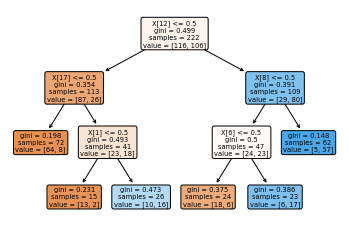

In [60]:
plot_tree(clf_dt_final, filled = True, rounded = True) #Plot the pruned tree


### Evaluation: The large tree is overfitted. A small tree works better